In [1]:
import numpy as np
import pandas as pd
data=pd.read_csv('D:/Datasets/dataset/train.csv')
pd.set_option("max_rows", None)
data

,Source,Host,Link,Date(ET),Time(ET),time(GMT),Title,TRANS_CONV_TEXT,Patient_Tag
0,FORUMS,cafepharma.com,http://cafepharma.com/boards/threads/epstein.5...,6/15/2016,13:58:00,6/15/2016 23:28,Epstein,I don't disagree with you in principle. I'm ju...,0
1,FORUMS,www.patient.co.uk,http://www.patient.co.uk/forums/discuss/enlarg...,5/7/2016,0.820833333,42498.21667,Enlarged Heart.Thread Enlarged Heart,I am always dizzy I get dizzy standing up so I...,1
2,BLOG,http://abcnewsradioonline.com/entertainment-news,http://abcnewsradioonline.com/entertainment-ne...,4/14/2016,15:00:38,4/15/2016 0:30,Queen Latifah Joins American Heart Association...,Axelle/Bauer-Griffin/FilmMagic(NEW YORK) -- Qu...,0
3,FORUMS,www.cancer-forums.net,http://www.cancer-forums.net/viewtopic.php?f=1...,6/18/2016,20:46:00,6/19/2016 6:16,Bulaemia,I am 17 and I have been throwing up for about ...,1
4,FORUMS,www.diyaudio.com,http://www.diyaudio.com/forums/lounge/292252-d...,6/15/2016,3:26:00,6/15/2016 12:56,DIY Silver interconnects and RCAs???,Quote: Originally Posted by Boyan Silyavski Wa...,0
5,FORUMS,forum.cyclinguk.org,http://forum.cyclinguk.org/viewtopic.php?f=24&...,4/6/2016,5:50:00,4/6/2016 15:20,Personal Question,Theres a discussion about recumbent power on B...,0
6,FORUMS,www.reddit.com,https://www.reddit.com/r/todayilearned/comment...,5/2/2016,0.047916667,42492.44375,TIL that CVS took a $2 billion hit to annual s...,Of course! I just got diagnosed with congestiv...,1
7,BLOG,http://quranfruitz.blogspot.com,http://quranfruitz.blogspot.com/2016/02/causes...,2/28/2016,3:20:00,2/28/2016 13:50,Causes of Low Blood Pressure(Hypo tension),Blood pressure is a measurement of the pressur...,0
8,FORUMS,hmnews.org,http://hmnews.org/health-care-news/cluster8641...,6/15/2016,17:16:00,6/16/2016 2:46,Sleep disorders may predict heart events after...,Other Sleep disorders may predict heart events...,0
9,FORUMS,www.cafepharma.com,http://www.cafepharma.com/boards/threads/nomin...,4/29/2016,23:46:00,4/30/2016 9:16,Nominations for worst manager at Novartis,worse manager ever??? LS out of Richmond. Ugh!...,0


In [2]:
import tensorflow as tf
print(tf.version.VERSION)

ModuleNotFoundError: No module named 'tensorflow'

In [15]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [21]:
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

D:\Anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [23]:
from sklearn.model_selection import train_test_split
data.shape

(1157, 9)

<AxesSubplot:title={'center':'Target Distribution'}, ylabel='Frequency'>

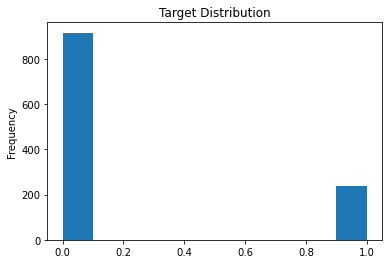

In [24]:
data.Patient_Tag.plot(kind="hist", title= "Target Distribution")

In [26]:
train_df, remaining = train_test_split(data, random_state=42, train_size=0.80, stratify=data.Patient_Tag.values)
validate_df, _  =train_test_split(remaining, random_state=42, train_size=0.80, stratify=remaining.Patient_Tag.values)
train_df.shape, validate_df.shape

((925, 9), (185, 9))

In [30]:
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices((train_df['Link'].values, train_df['Patient_Tag'].values))
    validate_data = tf.data.Dataset.from_tensor_slices((validate_df['Link'].values, validate_df['Patient_Tag'].values))
    
    for text, label in train_data.take(1):
        print(text)
        print(label)

tf.Tensor(b'http://boards.cruisecritic.com/showthread.php?t=2349785#post49847242', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [31]:
label_list = [0,1] # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32


# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case  = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [32]:
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
    example = classifier_data_lib.InputExample(guid=None, text_a=text.numpy(), text_b=None, label=label.numpy())
    feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
    
    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [33]:
def to_feature_map(text, label):
    input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], 
                                                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x={'input_word_ids' : input_ids, 
     'input_masks': input_mask, 
     'input_type_ids': segment_ids}

    return (x, label_id)

In [34]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  validate_data = (validate_data.map(to_feature_map, 
                                     num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

In [35]:
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_masks': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [36]:
validate_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_masks': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [37]:
def create_model():
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

    drop = tf.keras.layers.Dropout(0.4)(pooled_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)

    model = tf.keras.Model(inputs={'input_masks': input_mask, 'input_type_ids': input_type_ids, 'input_word_ids' : input_word_ids}, outputs = output)

    return (model)

In [38]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

In [39]:
tf.keras.utils.plot_model(model = model, show_shapes=True, dpi=76)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
epochs = 4
history = model.fit(train_data,
                  validation_data = validate_data, 
                  epochs=epochs,
                  verbose=1)  


Epoch 1/4
 4/28 [===>..........................] - ETA: 4:00:05 - loss: 0.6359 - binary_accuracy: 0.6875